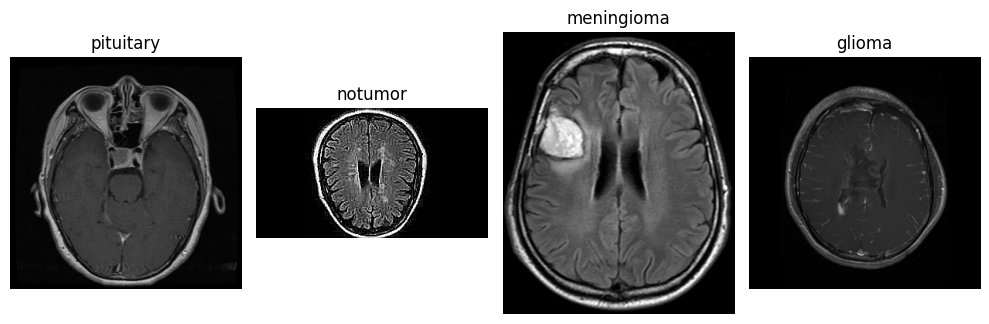

In [24]:
import os
import matplotlib.pyplot as plt
import cv2
import random

# Load one image from each class
data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
classes = os.listdir(data_dir)

plt.figure(figsize=(10, 5))
for i, cls in enumerate(classes):
    img_path = os.path.join(data_dir, cls, random.choice(os.listdir(os.path.join(data_dir, cls))))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()


Class Labels: ['glioma', 'meningioma', 'notumor', 'pituitary']

Image Counts Per Class:
             Image Count
glioma             1321
meningioma         1339
notumor            1595
pituitary          1457


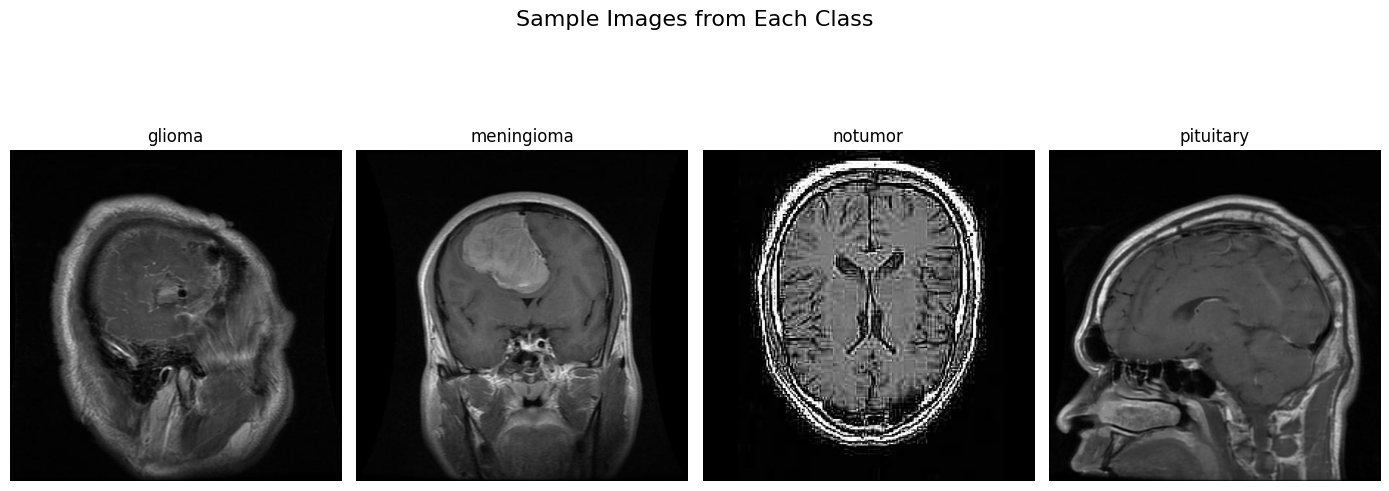

In [25]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Define dataset path (change this if not on Kaggle)
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'

# Show folder structure
classes = sorted(os.listdir(train_dir))
print("Class Labels:", classes)

# Count of images per class
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
print("\nImage Counts Per Class:\n", df_counts)

# Show sample images
plt.figure(figsize=(14, 6))
for i, cls in enumerate(classes):
    img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


In [26]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Set image dimensions
IMG_SIZE = 150  # You can change to 224 later for VGG/ResNet
DATA_DIR = '/kaggle/input/brain-tumor-mri-dataset/Training'
CLASSES = sorted(os.listdir(DATA_DIR))  # ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
print("Classes found:", CLASSES)

# Label mapping
label_map = {label: idx for idx, label in enumerate(CLASSES)}
print("Label Mapping:", label_map)

# Lists to hold data
X = []
y = []

# Loop through each class folder
for label in CLASSES:
    path = os.path.join(DATA_DIR, label)
    class_num = label_map[label]
    
    for img_name in tqdm(os.listdir(path), desc=f"Processing {label}"):
        img_path = os.path.join(path, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(class_num)
        except Exception as e:
            print(f"Failed on {img_path}: {e}")

# Convert to NumPy arrays
X = np.array(X) / 255.0  # Normalize pixel values
y = np.array(y)

print(f"\n✅ Shape of X: {X.shape}")
print(f"✅ Shape of y: {y.shape}")



Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']
Label Mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Processing pituitary: 100%|██████████| 1457/1457 [00:03<00:00, 370.27it/s]



✅ Shape of X: (5712, 150, 150, 3)
✅ Shape of y: (5712,)


In [27]:
from sklearn.model_selection import train_test_split

# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

# Second split: Temp → Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Final shapes
print("✅ Final Data Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

✅ Final Data Shapes:
X_train: (3998, 150, 150, 3), y_train: (3998,)
X_val:   (857, 150, 150, 3), y_val:   (857,)
X_test:  (857, 150, 150, 3), y_test:  (857,)


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test
val_test_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(
    X_train, y_train, batch_size=32, shuffle=True)

val_generator = val_test_datagen.flow(
    X_val, y_val, batch_size=32, shuffle=False)

test_generator = val_test_datagen.flow(
    X_test, y_test, batch_size=32, shuffle=False)

import warnings
warnings.filterwarnings('ignore')

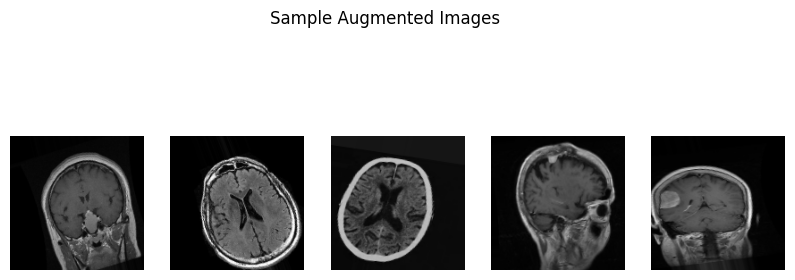

In [29]:
import matplotlib.pyplot as plt

# Show 5 augmented versions of one image
augmented_images = train_datagen.flow(X_train, y_train, batch_size=1)
plt.figure(figsize=(10, 4))
for i in range(5):
    batch = next(augmented_images)
    img = batch[0][0]  # Get the image from the batch
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Sample Augmented Images")
plt.show()


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()

# Conv Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Conv Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Conv Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Flatten + Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

import warnings
warnings.filterwarnings('ignore')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 74, 74, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,764 (18.42 MB)

 Trainable params: 4,829,316 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [31]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 823ms/step - accuracy: 0.5304 - loss: 1.3319 - val_accuracy: 0.2789 - val_loss: 1.6211
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 855ms/step - accuracy: 0.6580 - loss: 0.8753 - val_accuracy: 0.3057 - val_loss: 2.0229
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 813ms/step - accuracy: 0.6744 - loss: 0.8031 - val_accuracy: 0.3396 - val_loss: 3.2534
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 101s 809ms/step - accuracy: 0.7113 - loss: 0.7408 - val_accuracy: 0.4621 - val_loss: 1.7159
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 825ms/step - accuracy: 0.7260 - loss: 0.7050 - val_accuracy: 0.6651 - val_loss: 0.8510
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 111s 884ms/step - accuracy: 0.7362 - loss: 0.6515 - val_accuracy: 0.6768 - val_loss: 0.8473
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 134s 822ms/step - accuracy: 0.7587 - loss: 0.6252 - val_accuracy: 0.6814 - val_loss: 0.9777
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 859ms/step - accuracy: 0.7643 -

In [32]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.7546 - loss: 1.0284
Test Accuracy: 0.7480
Test Loss: 1.0260


In [36]:
y_pred_probs = model.predict(X_test)
print(y_pred_probs.shape)

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step
(857, 4)


In [37]:
from sklearn.preprocessing import LabelEncoder

# Assuming y is your original label list (e.g., ['glioma', 'pituitary', 'no_tumor', ...])
label_encoder = LabelEncoder()
label_encoder.fit(y)  # or label_encoder.fit(y_train + y_test) if needed


LabelEncoder()

In [38]:
from sklearn.preprocessing import LabelEncoder

# Define class names in the correct order
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Rebuild label encoder
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

LabelEncoder()

In [42]:
print("y_pred_probs shape:", y_pred_probs.shape)
print("y_test shape:", y_test.shape)

y_pred_probs shape: (857, 4)
y_test shape: (857,)


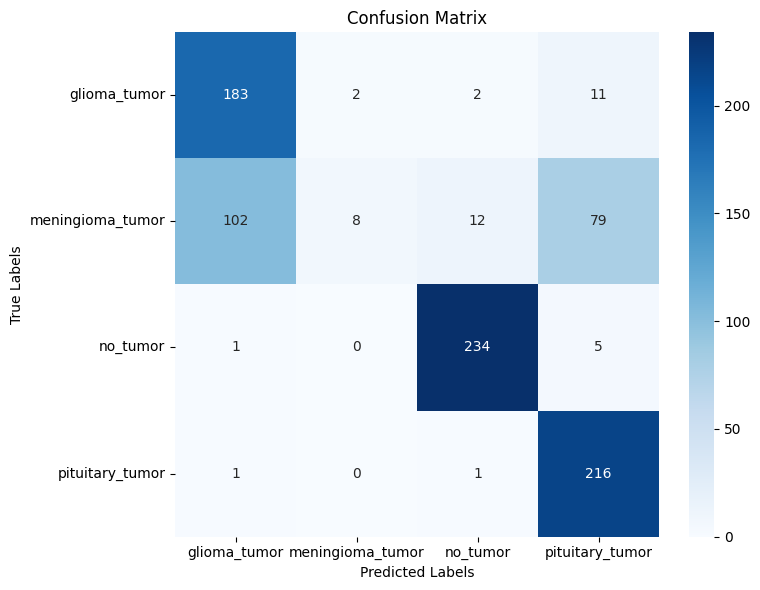

In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # shape (857,)
y_true_classes = y_test  # Already integer-encoded

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Fit the generator on training data
datagen.fit(X_train)

# Use this instead of model.fit()
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30  # Try increasing epochs
)


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 825ms/step - accuracy: 0.8483 - loss: 0.3708 - val_accuracy: 0.8506 - val_loss: 0.4594
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 821ms/step - accuracy: 0.8654 - loss: 0.3574 - val_accuracy: 0.7795 - val_loss: 0.7898
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 818ms/step - accuracy: 0.8769 - loss: 0.3456 - val_accuracy: 0.7876 - val_loss: 0.6609
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 101s 810ms/step - accuracy: 0.8670 - loss: 0.3405 - val_accuracy: 0.7783 - val_loss: 0.7838
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 101s 806ms/step - accuracy: 0.8819 - loss: 0.3094 - val_accuracy: 0.8810 - val_loss: 0.3461
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 840ms/step - accuracy: 0.8707 - loss: 0.3348 - val_accuracy: 0.8775 - val_loss: 0.3900
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 801ms/step - accuracy: 0.8697 - loss: 0.3269 - val_accuracy: 0.8751 - val_loss: 0.4368
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 818ms/step - accuracy: 0.8816 -

In [46]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 without top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base model

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

import warnings
warnings.filterwarnings('ignore')

In [47]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 without top layers, using ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers (no training)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # because labels are one-hot encoded
    metrics=['accuracy']
)

# Summary (optional)
model.summary()


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 1,049,220 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

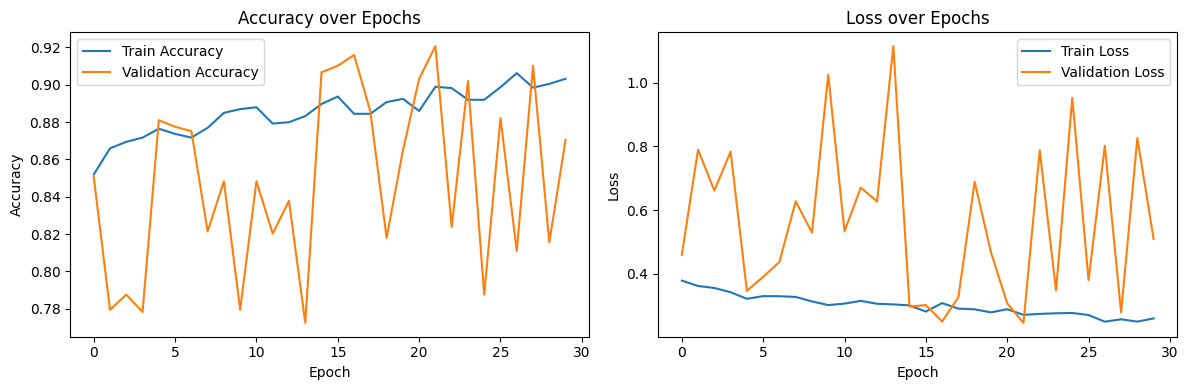

In [49]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step


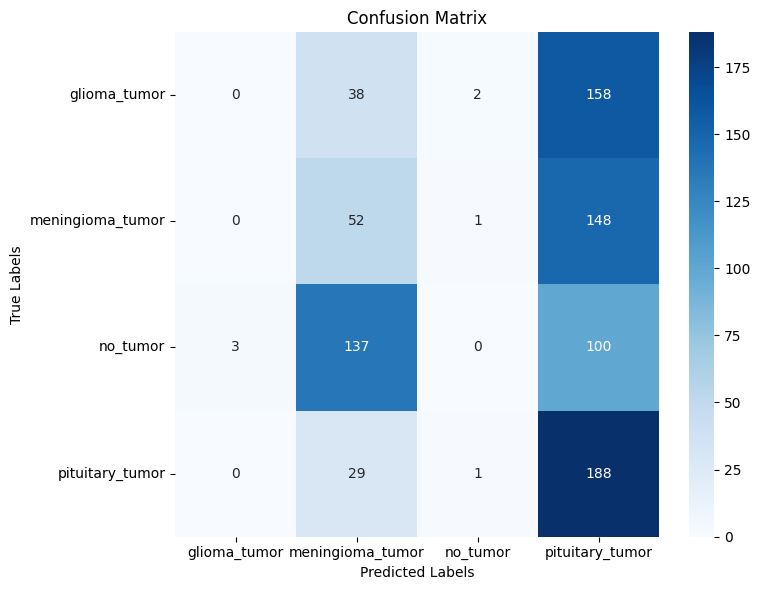

                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00       198
meningioma_tumor       0.20      0.26      0.23       201
        no_tumor       0.00      0.00      0.00       240
 pituitary_tumor       0.32      0.86      0.46       218

        accuracy                           0.28       857
       macro avg       0.13      0.28      0.17       857
    weighted avg       0.13      0.28      0.17       857



In [50]:
# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# If y_test is categorical (e.g., one-hot), convert it to class labels
# y_test = np.argmax(y_test, axis=1)  # ONLY if y_test is one-hot
# But since yours is shape (857,), it’s already integer labels — so skip above line

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


In [58]:
model.save("final_brain_mri_classifier_model.h5")